## Con colores.

In [30]:
import tensorflow as tf
import numpy as np
import cv2

# ----------------------------
# Parámetros de imagen
# ----------------------------
img_height = 224
img_width  = 224
batch_size = 32

# ----------------------------
# Rutas de los datasets
# ----------------------------
train_dir = r"C:\Users\aserr\Downloads\002.Cancer\train"
test_dir  = r"C:\Users\aserr\Downloads\002.Cancer\test"

# ----------------------------
# Funciones de preprocesado
# ----------------------------
def apply_heatmap_safe(img_tensor):
    img = img_tensor.numpy()
    img = (img * 255).astype('uint8')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap = heatmap.astype('float32') / 255.0
    return heatmap

def preprocess_with_heatmap(img, label):
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0

    def heat():
        return tf.py_function(apply_heatmap_safe, [img], Tout=tf.float32)

    # 40% de imágenes en heatmap
    img_final = tf.cond(tf.random.uniform([]) < 0.4, heat, lambda: img)
    img_final.set_shape([img_height, img_width, 3])
    return img_final, label

# ----------------------------
# Cargar dataset de entrenamiento
# ----------------------------
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=None
)

# Crear validación a partir del train (80% train, 20% val)
train_size = int(0.8 * len(full_train_ds))
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Aplicar preprocesado con heatmaps
train_ds = train_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)

# Preparar batches y prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Dataset de test
# ----------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=None
)

test_ds = test_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset listo con 40% de imágenes en heatmap")


Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
✅ Dataset listo con 40% de imágenes en heatmap


Class weights: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}
Epoch 1/22


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 173s 579ms/step - accuracy: 0.6913 - loss: 0.5787 - val_accuracy: 0.7391 - val_loss: 0.5150
Epoch 2/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 168s 567ms/step - accuracy: 0.7747 - loss: 0.4654 - val_accuracy: 0.7866 - val_loss: 0.4362
Epoch 3/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8011 - loss: 0.4224 - val_accuracy: 0.8178 - val_loss: 0.3824
Epoch 4/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8174 - loss: 0.3916 - val_accuracy: 0.8304 - val_loss: 0.3640
Epoch 5/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 567ms/step - accuracy: 0.8330 - loss: 0.3692 - val_accuracy: 0.8384 - val_loss: 0.3712
Epoch 6/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8432 - loss: 0.3483 - val_accuracy: 0.8472 - val_loss: 0.3359
Epoch 7/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 569ms/step - accuracy: 0.8566 - loss: 0.3301 - val_accuracy: 0.8594 - val_loss: 0.3140
Epoch 8/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 170s 571ms/step - accuracy: 0.8725 - loss: 0.29

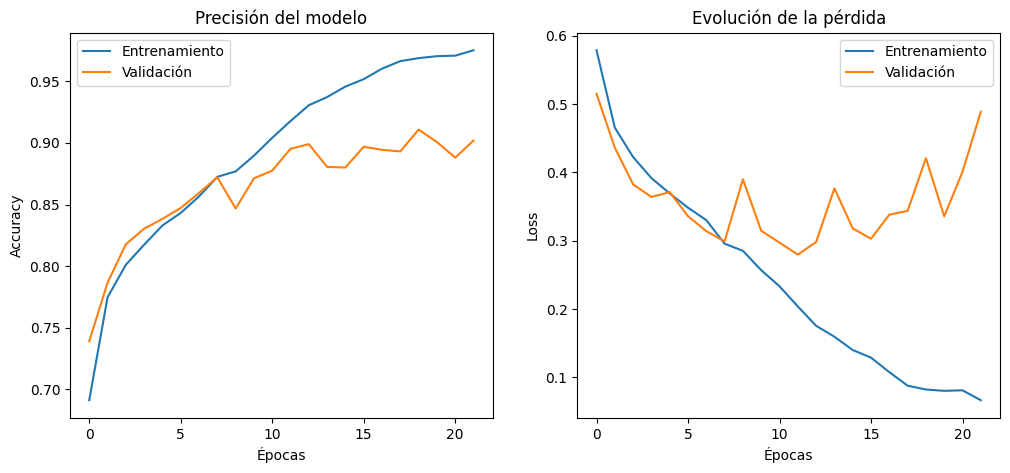

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step


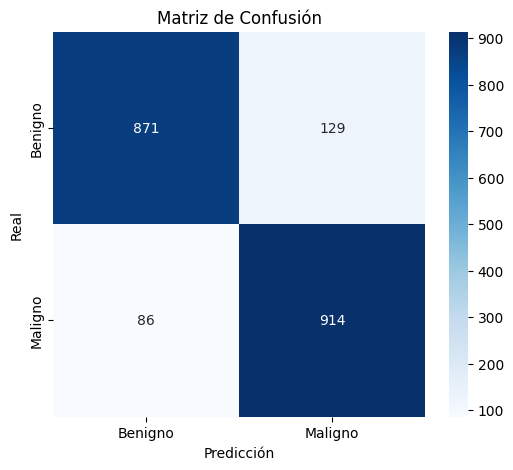

              precision    recall  f1-score   support

     Benigno       0.91      0.87      0.89      1000
     Maligno       0.88      0.91      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


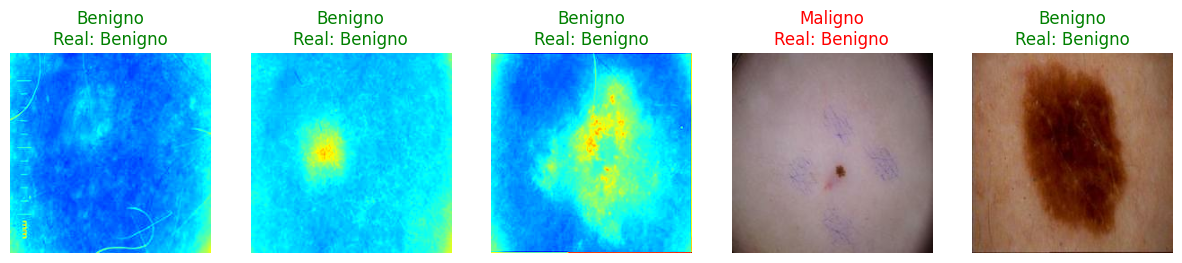

✅ Modelo guardado como modelo_cnn.h5


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2


# ----------------------------
# Calcular pesos de clase para balancear
# ----------------------------
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ----------------------------
# Crear modelo CNN (como tu versión original)
# ----------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Entrenamiento
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=22,
    class_weight=class_weights
)

# ----------------------------
# Evaluación en test
# ----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ----------------------------
# Gráficas de Accuracy y Loss
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------------------------
# Matriz de confusión y reporte
# ----------------------------
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Mostrar 5 imágenes aleatorias con predicción
# ----------------------------
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx].numpy())
        plt.axis("off")
        color_warning = "red" if preds_classes[idx] == 1 else "green"
        plt.title(f"{class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color_warning)
plt.show()

# ----------------------------
# Guardar modelo
# ----------------------------
model.save("modelo_cnn.h5")
print("✅ Modelo guardado como modelo_cnn.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


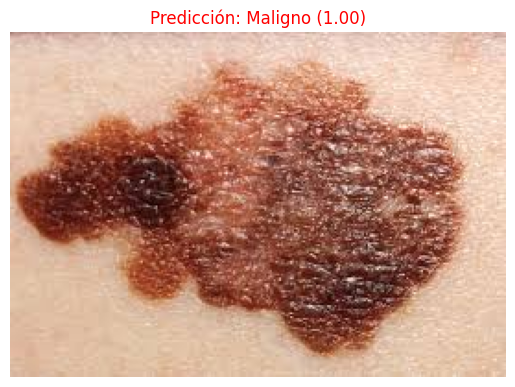

👉 Resultado: Maligno con probabilidad 1.00


In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Función para analizar imagen
# ============================
def analizar_imagen(ruta_imagen, model, img_height=224, img_width=224, threshold=0.4):
    # Cargar la imagen
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    # Normalizar a [0,1]
    img_array = img_array / 255.0

    # Añadir dimensión batch
    img_array = np.expand_dims(img_array, axis=0)

    # Predicción
    pred = model.predict(img_array)[0][0]

    # Clasificación
    clase = "Maligno" if pred > threshold else "Benigno"

    # Mostrar resultado
    plt.imshow(tf.keras.utils.load_img(ruta_imagen))
    plt.axis("off")
    plt.title(f"Predicción: {clase} ({pred:.2f})", color="red" if clase=="Maligno" else "green")
    plt.show()

    return clase, pred

# ============================
# Uso de la función
# ============================
ruta = "C:/Users/aserr/Downloads/FotoMelanoma1.jpeg"  # <-- pon aquí la ruta de tu imagen
clase, prob = analizar_imagen(ruta, model)
print(f"👉 Resultado: {clase} con probabilidad {prob:.2f}")
